In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.io import wavfile

Fourier Series

In [23]:
def getFourierCoeffs(coefs, T, K=50):
    coefs = np.asarray(coefs, dtype=float)
    T = np.asarray(T, dtype=float)
    n = coefs.shape[0]

    alpha = coefs[:, 0]
    beta  = coefs[:, 1]
    gamma = coefs[:, 2]
    delta = coefs[:, 3]

    tau = T[1:] - T[:-1]   
    L = T[-1] - T[0]
    if L == 0:
        raise ValueError("Total length L = T[-1] - T[0] must be nonzero.")

    a0 = (1.0 / L) * np.sum(
        alpha * (tau**4) / 4.0
        + beta  * (tau**3) / 3.0
        + gamma * (tau**2) / 2.0
        + delta * (tau)
    )

    ak = np.zeros(K, dtype=float)
    bk = np.zeros(K, dtype=float)

    T_i = T[:-1]     
    T_ip1 = T[1:]    

    for k in range(1, K+1):
        omega = 2.0 * np.pi * k / L
        w1 = omega
        w2 = omega**2
        w3 = omega**3
        w4 = omega**4

        sin_Ti   = np.sin(w1 * T_i)
        sin_Tip1 = np.sin(w1 * T_ip1)
        cos_Ti   = np.cos(w1 * T_i)
        cos_Tip1 = np.cos(w1 * T_ip1)

        term_alpha_a = (
            alpha * (
                (tau**3 * sin_Tip1) / w1
                + (3.0 * tau**2 * cos_Tip1) / w2
                - (6.0 * tau * sin_Tip1) / w3
                - (6.0 * (cos_Tip1 - cos_Ti)) / w4
            )
        )

        term_beta_a = (
            beta * (
                (tau**2 * sin_Tip1) / w1
                + (2.0 * tau * cos_Tip1) / w2
                - (2.0 * (sin_Tip1 - sin_Ti)) / w3
            )
        )

        term_gamma_a = (
            gamma * (
                (tau * sin_Tip1) / w1
                + (cos_Tip1 - cos_Ti) / w2
            )
        )

        term_delta_a = (
            delta * ( (sin_Tip1 - sin_Ti) / w1 )
        )

        sum_a_intervals = np.sum(term_alpha_a + term_beta_a + term_gamma_a + term_delta_a)
        ak[k-1] = (2.0 / L) * sum_a_intervals

        term_alpha_b = (
            alpha * (
                - (tau**3 * cos_Tip1) / w1
                + (3.0 * tau**2 * sin_Tip1) / w2
                + (6.0 * tau * cos_Tip1) / w3
                - (6.0 * (sin_Tip1 - sin_Ti)) / w4
            )
        )

        term_beta_b = (
            beta * (
                - (tau**2 * cos_Tip1) / w1
                + (2.0 * tau * sin_Tip1) / w2
                + (2.0 * (cos_Tip1 - cos_Ti)) / w3
            )
        )

        term_gamma_b = (
            gamma * (
                - (tau * cos_Tip1) / w1
                + (sin_Tip1 - sin_Ti) / w2
            )
        )

        term_delta_b = (
            delta * ( - (cos_Tip1 - cos_Ti) / w1 )
        )

        sum_b_intervals = np.sum(term_alpha_b + term_beta_b + term_gamma_b + term_delta_b)
        bk[k-1] = (2.0 / L) * sum_b_intervals

    return a0, ak, bk

In [24]:
def fourier_series(t, terms, a0, ak, bk, L):
    t = np.asarray(t, dtype=float)
    y = np.full_like(t, a0, dtype=float)
    for k in range(1, terms+1):
        omega = 2 * np.pi * k / L
        y += ak[k-1] * np.cos(omega * t) + bk[k-1] * np.sin(omega * t)
    return y

In [25]:
def visualizeFourier(data):
    x = data.iloc[:, 0].values
    y = data.iloc[:, 1].values

    cs = CubicSpline(x, y)

    x_smooth = np.linspace(min(x), max(x), 500)
    y_smooth = cs(x_smooth)
    cubicSpline = np.transpose(cs.c)

    a0, ak, bk = getFourierCoeffs(coefs=cubicSpline, T=x, K=50)

    L = x[-1] - x[0]

    terms = 50

    t_plot_long = np.linspace(x[0] - L, x[-1] + L, 4000)
    y_fourier_long = fourier_series(t_plot_long, terms, a0, ak, bk, L)

    plt.figure(figsize=(10,5))
    plt.plot(t_plot_long, y_fourier_long,
                label=f"Fourier Series (K={terms})", linewidth=2)

    plt.scatter(x, y, color='red', s=12, label="Original Data", zorder=5)

    plt.axvline(x[0], color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x[-1], color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x[0] - L, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x[-1] + L, color='gray', linestyle='--', alpha=0.3)

    plt.title("Fourier Series Reconstruction (Extended to Show Periodicity)")
    plt.xlabel("t")
    plt.ylabel("s(t)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


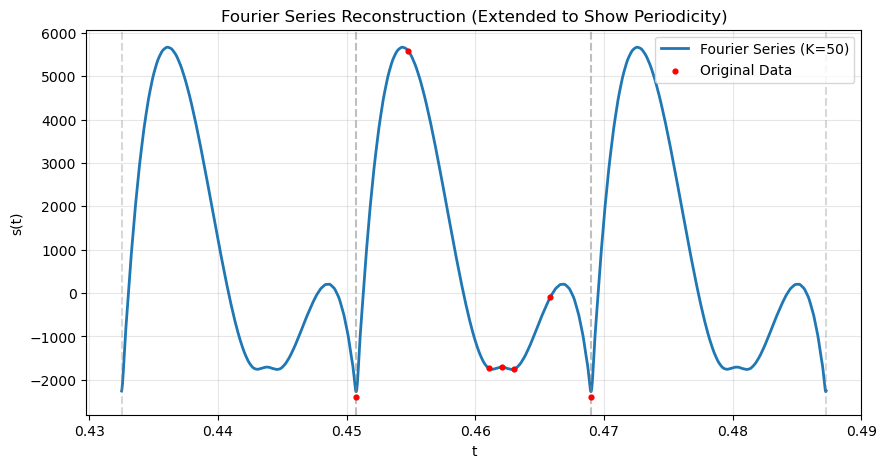

In [26]:
data = pd.read_csv("./plot_data/Bass A4 (A2).csv", header=None)
visualizeFourier(data)


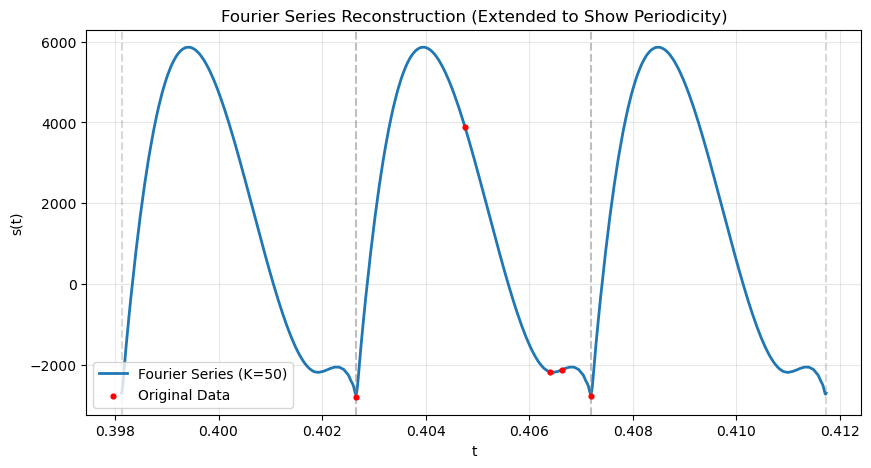

In [27]:
data = pd.read_csv("./plot_data/Guitar A4.csv", header=None)
visualizeFourier(data)

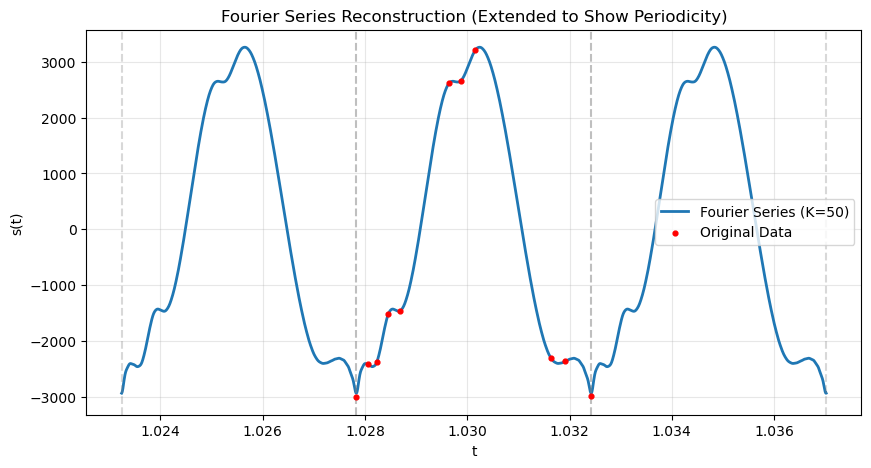

In [28]:
data = pd.read_csv("./plot_data/Violin A4.csv", header=None)
visualizeFourier(data)

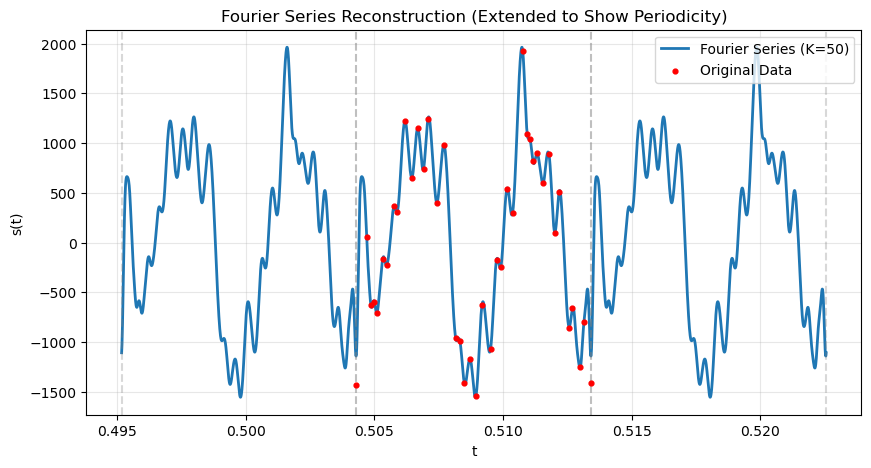

In [29]:
data = pd.read_csv("./plot_data/Violin A4-E5.csv", header=None)
data = data.sort_values(by=0)
visualizeFourier(data)

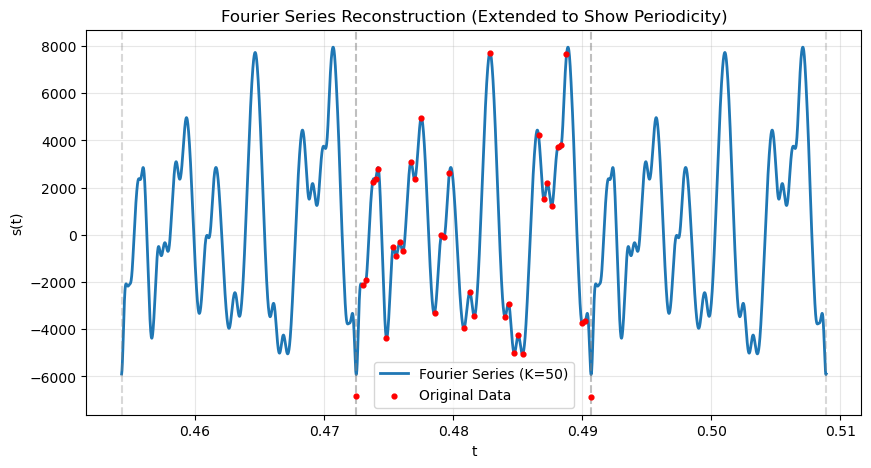

In [30]:
data = pd.read_csv("./plot_data/Guitar A Major.csv", header=None)
visualizeFourier(data)

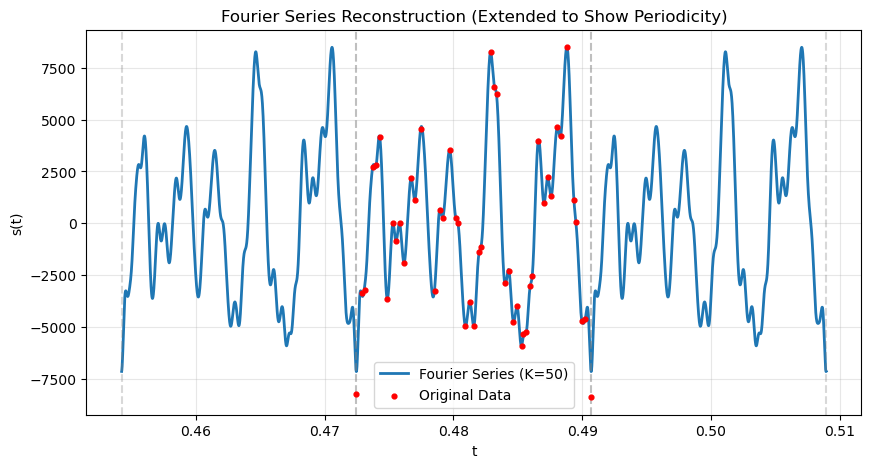

In [31]:
data = pd.read_csv("./plot_data/Violin + Guitar.csv", header=None)
data = data.sort_values(by=0)
visualizeFourier(data)

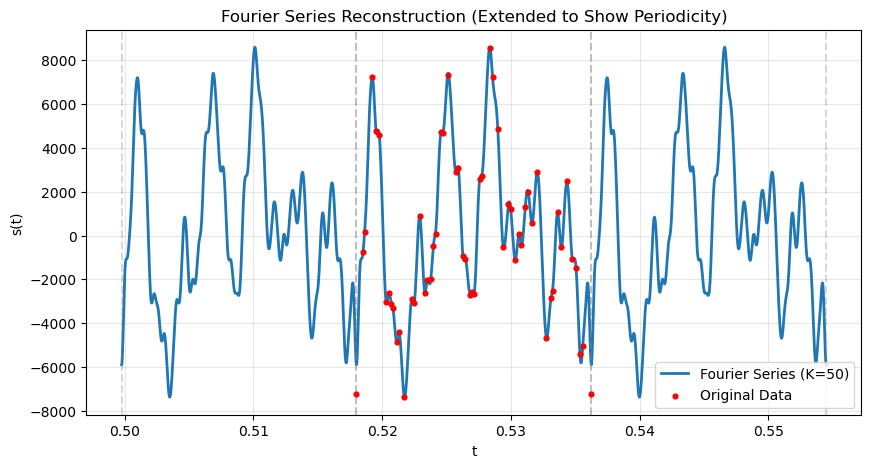

In [32]:
data = pd.read_csv("./plot_data/All Three.csv", header=None)
visualizeFourier(data)

In [33]:
def synthesize_to_wav(csv_path, out_name, K=50, sample_rate=44100, duration_sec=10):

    out_dir = "audio_fs"
    os.makedirs(out_dir, exist_ok=True)
    wav_path = os.path.join(out_dir, out_name)
    
    df = pd.read_csv(csv_path, header=None)
    df = df.sort_values(by=0)

    x = df.iloc[:,0].values.astype(float)
    y = df.iloc[:,1].values.astype(float)

    cs = CubicSpline(x, y)
    spline_coefs = cs.c.T

    a0, ak, bk = getFourierCoeffs(spline_coefs, x, K)

    L = x[-1] - x[0]
    samples_one_period = int(sample_rate * L)

    t = np.linspace(x[0], x[-1], samples_one_period, endpoint=False)
    y_period = fourier_series(t, K, a0, ak, bk, L)

    total_samples = int(duration_sec * sample_rate)
    repeats = int(np.ceil(total_samples / samples_one_period))

    y_long = np.tile(y_period, repeats)[:total_samples]
    y_long = y_long / np.max(np.abs(y_long)) * 0.95
    wav = (y_long * 32767).astype(np.int16)

    wavfile.write(wav_path, sample_rate, wav)
    print(f"Saved → {wav_path}")

In [34]:
synthesize_to_wav("./plot_data/Bass A4 (A2).csv",     "./BassA4.wav")
synthesize_to_wav("./plot_data/Guitar A4.csv",        "./GuitarA4.wav")
synthesize_to_wav("./plot_data/Violin A4.csv",        "./ViolinA4.wav")
synthesize_to_wav("./plot_data/Violin A4-E5.csv",     "./ViolinA4E5.wav")
synthesize_to_wav("./plot_data/Guitar A Major.csv",   "./GuitarAMajor.wav")
synthesize_to_wav("./plot_data/Violin + Guitar.csv",  "./ViolinGuitar.wav")
synthesize_to_wav("./plot_data/All Three.csv",        "./AllThree.wav")

Saved → audio_fs\./BassA4.wav
Saved → audio_fs\./GuitarA4.wav
Saved → audio_fs\./ViolinA4.wav
Saved → audio_fs\./ViolinA4E5.wav
Saved → audio_fs\./GuitarAMajor.wav
Saved → audio_fs\./ViolinGuitar.wav
Saved → audio_fs\./AllThree.wav


Fourier Transform

In [35]:
def visualizeFourierTransform(data, name, threshold, sigma=2.0, w_limit=4000, K=50, n_freq=10000):

    x = np.asarray(data.iloc[:, 0])
    y = np.asarray(data.iloc[:, 1])
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    if x.size < 2:
        raise ValueError("Need at least two x samples.")
    if x.size != y.size:
        raise ValueError("x and y must have same length.")

    cs = CubicSpline(x, y)
    cubicSpline = np.transpose(cs.c)  

    T_scalar = x[-1] - x[0]
    if T_scalar <= 0:
        raise ValueError("Invalid x range (no span).")

    a0, ak, bk = getFourierCoeffs(cubicSpline, x, K=K)

    ak = np.asarray(ak, float)
    bk = np.asarray(bk, float)
    if ak.size != bk.size:
        raise ValueError("ak and bk must have the same length after getFourierCoeffs.")
    if ak.size == 0:
        raise ValueError("No harmonics returned by getFourierCoeffs.")

    Kret = ak.size
    ks = np.arange(1, Kret + 1)
    omega0 = 2.0 * np.pi / T_scalar
    omega = np.linspace(0, w_limit, n_freq)

    def delta_approx(w, w0):
        return np.exp(-0.5 * ((w - w0) / sigma) ** 2)

    FT = np.zeros_like(omega, dtype=np.complex128)
    FT += 2.0 * np.pi * a0 * delta_approx(omega, 0.0)

    for i, k in enumerate(ks):
        wk = k * omega0
        FT += np.pi * (ak[i] - 1j * bk[i]) * delta_approx(omega,  wk)
        FT += np.pi * (ak[i] + 1j * bk[i]) * delta_approx(omega, -wk)

    mag = np.abs(FT)
    dom_mask = mag > threshold
    dom_omega = omega[dom_mask]

    if dom_omega.size:
        print(f"\nDominant Frequencies (|F(ω)| > {threshold}):")
        for w in dom_omega:
            f = w / (2.0 * np.pi)
            print(f"ω = {w:.2f} rad/s   f = {f:.4f} Hz")
    else:
        print(f"\nNo frequencies with |F(ω)| > {threshold} found in ±{w_limit} rad/s.")

    plt.figure(figsize=(10, 4))
    plt.plot(omega, mag)
    plt.xlim([0, w_limit])
    plt.xlabel("Frequency ω (rad/s)")
    plt.ylabel("|F(ω)|")
    plt.title("Fourier Transform Magnitude " + name)
    plt.grid(True)
    plt.show()

    return {
        "omega": omega,
        "FT": FT,
        "a0": a0,
        "ak": ak,
        "bk": bk,
        "omega0": omega0,
        "T": T_scalar
    }


Dominant Frequencies (|F(ω)| > 2000):
ω = 0.00 rad/s   f = 0.0000 Hz
ω = 0.40 rad/s   f = 0.0637 Hz
ω = 0.80 rad/s   f = 0.1273 Hz
ω = 1.20 rad/s   f = 0.1910 Hz
ω = 1.60 rad/s   f = 0.2547 Hz
ω = 2.00 rad/s   f = 0.3183 Hz
ω = 2.40 rad/s   f = 0.3820 Hz
ω = 2.80 rad/s   f = 0.4457 Hz
ω = 340.83 rad/s   f = 54.2454 Hz
ω = 341.23 rad/s   f = 54.3091 Hz
ω = 341.63 rad/s   f = 54.3728 Hz
ω = 342.03 rad/s   f = 54.4364 Hz
ω = 342.43 rad/s   f = 54.5001 Hz
ω = 342.83 rad/s   f = 54.5638 Hz
ω = 343.23 rad/s   f = 54.6274 Hz
ω = 343.63 rad/s   f = 54.6911 Hz
ω = 344.03 rad/s   f = 54.7548 Hz
ω = 344.43 rad/s   f = 54.8184 Hz
ω = 344.83 rad/s   f = 54.8821 Hz
ω = 345.23 rad/s   f = 54.9458 Hz
ω = 345.63 rad/s   f = 55.0094 Hz
ω = 346.03 rad/s   f = 55.0731 Hz
ω = 346.43 rad/s   f = 55.1368 Hz
ω = 346.83 rad/s   f = 55.2005 Hz
ω = 347.23 rad/s   f = 55.2641 Hz
ω = 347.63 rad/s   f = 55.3278 Hz
ω = 686.07 rad/s   f = 109.1912 Hz
ω = 686.47 rad/s   f = 109.2549 Hz
ω = 686.87 rad/s   f = 109.3185

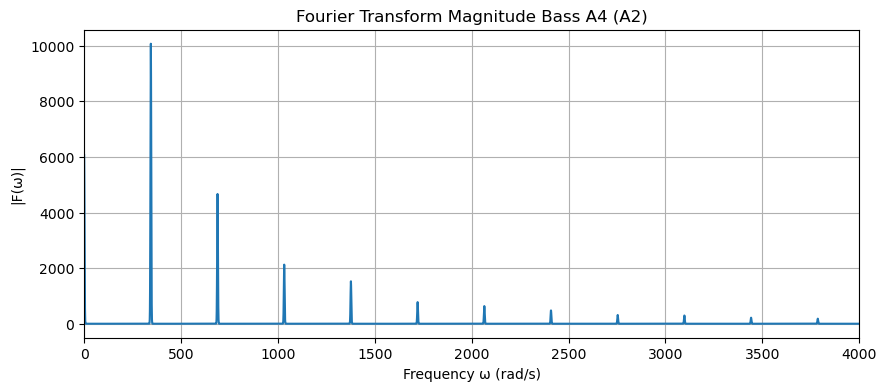

In [36]:
data = pd.read_csv("./plot_data/Bass A4 (A2).csv", header=None)
res = visualizeFourierTransform(data, "Bass A4 (A2)", 2000)


Dominant Frequencies (|F(ω)| > 2000):
ω = 0.00 rad/s   f = 0.0000 Hz
ω = 0.40 rad/s   f = 0.0637 Hz
ω = 0.80 rad/s   f = 0.1273 Hz
ω = 1.20 rad/s   f = 0.1910 Hz
ω = 1.60 rad/s   f = 0.2547 Hz
ω = 2.00 rad/s   f = 0.3183 Hz
ω = 2.40 rad/s   f = 0.3820 Hz
ω = 2.80 rad/s   f = 0.4457 Hz
ω = 3.20 rad/s   f = 0.5093 Hz
ω = 1381.74 rad/s   f = 219.9105 Hz
ω = 1382.14 rad/s   f = 219.9741 Hz
ω = 1382.54 rad/s   f = 220.0378 Hz
ω = 1382.94 rad/s   f = 220.1015 Hz
ω = 1383.34 rad/s   f = 220.1651 Hz
ω = 1383.74 rad/s   f = 220.2288 Hz
ω = 1384.14 rad/s   f = 220.2925 Hz
ω = 1384.54 rad/s   f = 220.3561 Hz
ω = 1384.94 rad/s   f = 220.4198 Hz
ω = 1385.34 rad/s   f = 220.4835 Hz
ω = 1385.74 rad/s   f = 220.5471 Hz
ω = 1386.14 rad/s   f = 220.6108 Hz
ω = 1386.54 rad/s   f = 220.6745 Hz
ω = 1386.94 rad/s   f = 220.7381 Hz
ω = 1387.34 rad/s   f = 220.8018 Hz
ω = 1387.74 rad/s   f = 220.8655 Hz
ω = 1388.14 rad/s   f = 220.9292 Hz
ω = 1388.54 rad/s   f = 220.9928 Hz
ω = 1388.94 rad/s   f = 221.0565 H

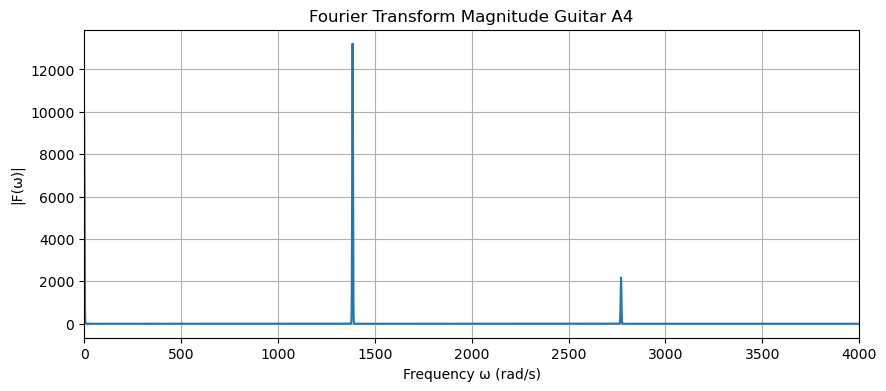

In [37]:
data = pd.read_csv("./plot_data/Guitar A4.csv", header=None)
res = visualizeFourierTransform(data, "Guitar A4", 2000)


Dominant Frequencies (|F(ω)| > 1500):
ω = 1364.54 rad/s   f = 217.1727 Hz
ω = 1364.94 rad/s   f = 217.2364 Hz
ω = 1365.34 rad/s   f = 217.3001 Hz
ω = 1365.74 rad/s   f = 217.3637 Hz
ω = 1366.14 rad/s   f = 217.4274 Hz
ω = 1366.54 rad/s   f = 217.4911 Hz
ω = 1366.94 rad/s   f = 217.5547 Hz
ω = 1367.34 rad/s   f = 217.6184 Hz
ω = 1367.74 rad/s   f = 217.6821 Hz
ω = 1368.14 rad/s   f = 217.7457 Hz
ω = 1368.54 rad/s   f = 217.8094 Hz
ω = 1368.94 rad/s   f = 217.8731 Hz
ω = 1369.34 rad/s   f = 217.9367 Hz
ω = 1369.74 rad/s   f = 218.0004 Hz
ω = 1370.14 rad/s   f = 218.0641 Hz
ω = 1370.54 rad/s   f = 218.1277 Hz
ω = 1370.94 rad/s   f = 218.1914 Hz
ω = 1371.34 rad/s   f = 218.2551 Hz
ω = 1371.74 rad/s   f = 218.3188 Hz
ω = 1372.14 rad/s   f = 218.3824 Hz
ω = 2735.87 rad/s   f = 435.4278 Hz
ω = 2736.27 rad/s   f = 435.4915 Hz
ω = 2736.67 rad/s   f = 435.5551 Hz
ω = 2737.07 rad/s   f = 435.6188 Hz
ω = 2737.47 rad/s   f = 435.6825 Hz


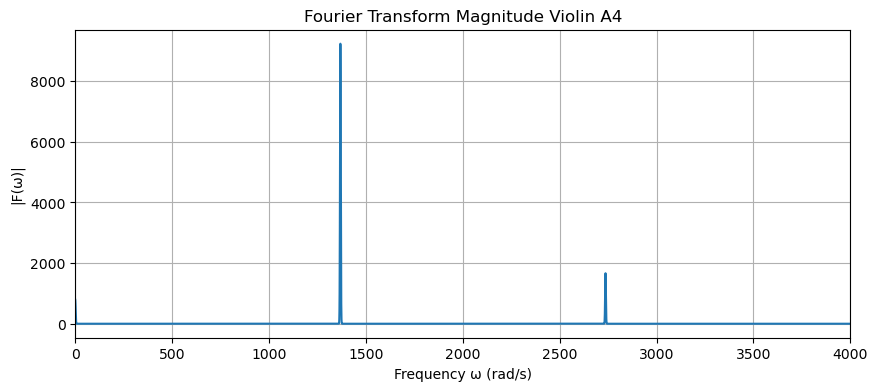

In [38]:
data = pd.read_csv("./plot_data/Violin A4.csv", header=None)
res = visualizeFourierTransform(data, "Violin A4", 1500)


Dominant Frequencies (|F(ω)| > 2000):
ω = 688.47 rad/s   f = 109.5732 Hz
ω = 688.87 rad/s   f = 109.6369 Hz
ω = 689.27 rad/s   f = 109.7006 Hz
ω = 689.67 rad/s   f = 109.7642 Hz
ω = 690.07 rad/s   f = 109.8279 Hz
ω = 690.47 rad/s   f = 109.8916 Hz
ω = 690.87 rad/s   f = 109.9552 Hz
ω = 691.27 rad/s   f = 110.0189 Hz
ω = 691.67 rad/s   f = 110.0826 Hz
ω = 692.07 rad/s   f = 110.1462 Hz
ω = 692.47 rad/s   f = 110.2099 Hz
ω = 692.87 rad/s   f = 110.2736 Hz
ω = 1032.90 rad/s   f = 164.3917 Hz
ω = 1033.30 rad/s   f = 164.4553 Hz
ω = 1033.70 rad/s   f = 164.5190 Hz
ω = 1034.10 rad/s   f = 164.5827 Hz
ω = 1034.50 rad/s   f = 164.6463 Hz
ω = 1034.90 rad/s   f = 164.7100 Hz
ω = 1035.30 rad/s   f = 164.7737 Hz
ω = 1035.70 rad/s   f = 164.8373 Hz
ω = 1036.10 rad/s   f = 164.9010 Hz
ω = 1036.50 rad/s   f = 164.9647 Hz
ω = 1036.90 rad/s   f = 165.0283 Hz
ω = 1037.30 rad/s   f = 165.0920 Hz
ω = 1037.70 rad/s   f = 165.1557 Hz
ω = 1038.10 rad/s   f = 165.2194 Hz
ω = 1038.50 rad/s   f = 165.2830 Hz
ω

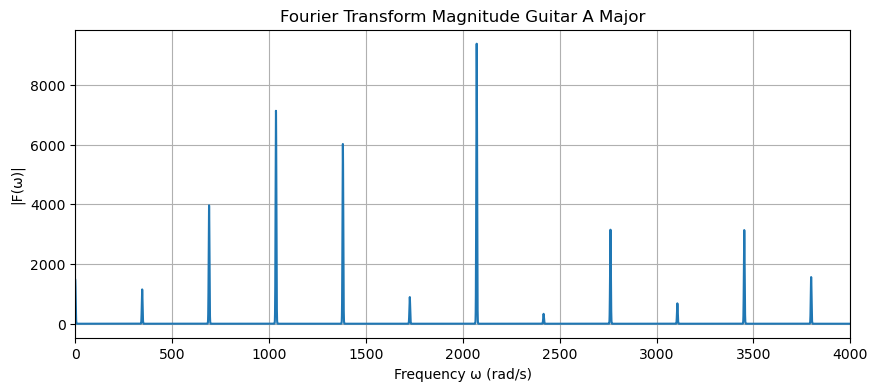

In [39]:
data = pd.read_csv("./plot_data/Guitar A Major.csv", header=None)
res = visualizeFourierTransform(data, "Guitar A Major", 2000)


Dominant Frequencies (|F(ω)| > 1000):
ω = 1374.14 rad/s   f = 218.7008 Hz
ω = 1374.54 rad/s   f = 218.7644 Hz
ω = 1374.94 rad/s   f = 218.8281 Hz
ω = 1375.34 rad/s   f = 218.8918 Hz
ω = 1375.74 rad/s   f = 218.9554 Hz
ω = 1376.14 rad/s   f = 219.0191 Hz
ω = 1376.54 rad/s   f = 219.0828 Hz
ω = 1376.94 rad/s   f = 219.1464 Hz
ω = 1377.34 rad/s   f = 219.2101 Hz
ω = 1377.74 rad/s   f = 219.2738 Hz
ω = 1378.14 rad/s   f = 219.3374 Hz
ω = 1378.54 rad/s   f = 219.4011 Hz
ω = 1378.94 rad/s   f = 219.4648 Hz
ω = 1379.34 rad/s   f = 219.5285 Hz
ω = 1379.74 rad/s   f = 219.5921 Hz
ω = 2065.01 rad/s   f = 328.6560 Hz
ω = 2065.41 rad/s   f = 328.7197 Hz


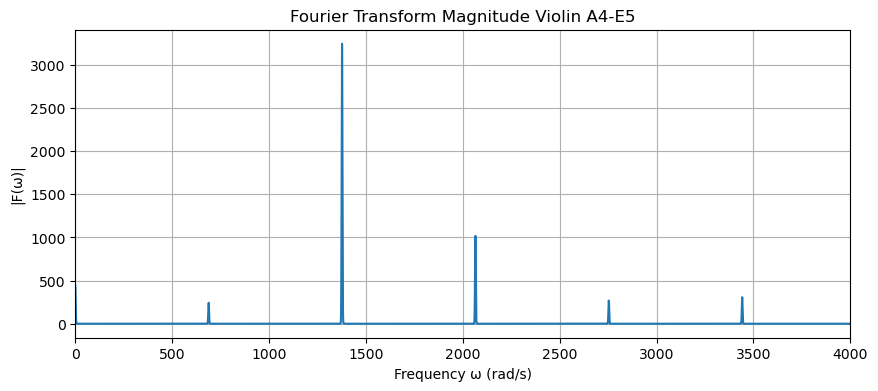

In [40]:
data = pd.read_csv("./plot_data/Violin A4-E5.csv", header=None)
res = visualizeFourierTransform(data, "Violin A4-E5", 1000)


Dominant Frequencies (|F(ω)| > 1000):
ω = 686.47 rad/s   f = 109.2549 Hz
ω = 686.87 rad/s   f = 109.3185 Hz
ω = 687.27 rad/s   f = 109.3822 Hz
ω = 687.67 rad/s   f = 109.4459 Hz
ω = 688.07 rad/s   f = 109.5096 Hz
ω = 688.47 rad/s   f = 109.5732 Hz
ω = 688.87 rad/s   f = 109.6369 Hz
ω = 689.27 rad/s   f = 109.7006 Hz
ω = 689.67 rad/s   f = 109.7642 Hz
ω = 690.07 rad/s   f = 109.8279 Hz
ω = 690.47 rad/s   f = 109.8916 Hz
ω = 690.87 rad/s   f = 109.9552 Hz
ω = 691.27 rad/s   f = 110.0189 Hz
ω = 691.67 rad/s   f = 110.0826 Hz
ω = 692.07 rad/s   f = 110.1462 Hz
ω = 1030.10 rad/s   f = 163.9460 Hz
ω = 1030.50 rad/s   f = 164.0097 Hz
ω = 1030.90 rad/s   f = 164.0733 Hz
ω = 1031.30 rad/s   f = 164.1370 Hz
ω = 1031.70 rad/s   f = 164.2007 Hz
ω = 1032.10 rad/s   f = 164.2643 Hz
ω = 1032.50 rad/s   f = 164.3280 Hz
ω = 1032.90 rad/s   f = 164.3917 Hz
ω = 1033.30 rad/s   f = 164.4553 Hz
ω = 1033.70 rad/s   f = 164.5190 Hz
ω = 1034.10 rad/s   f = 164.5827 Hz
ω = 1034.50 rad/s   f = 164.6463 Hz
ω = 

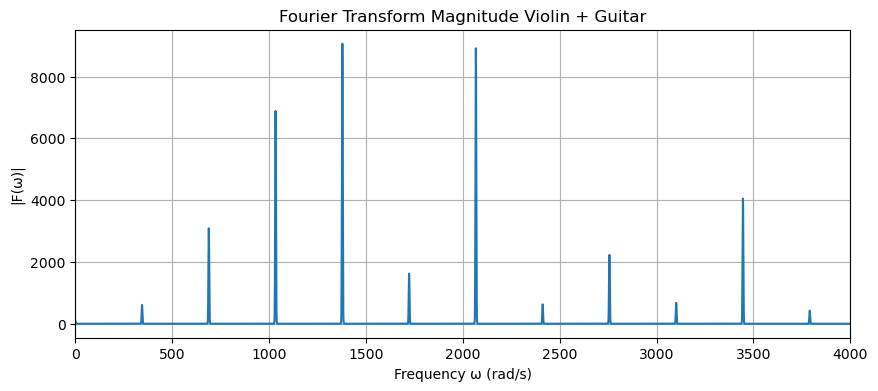

In [41]:
data = pd.read_csv("./plot_data/Violin + Guitar.csv", header=None)
res = visualizeFourierTransform(data, "Violin + Guitar", 1000)


Dominant Frequencies (|F(ω)| > 1000):
ω = 0.00 rad/s   f = 0.0000 Hz
ω = 0.40 rad/s   f = 0.0637 Hz
ω = 0.80 rad/s   f = 0.1273 Hz
ω = 340.83 rad/s   f = 54.2454 Hz
ω = 341.23 rad/s   f = 54.3091 Hz
ω = 341.63 rad/s   f = 54.3728 Hz
ω = 342.03 rad/s   f = 54.4364 Hz
ω = 342.43 rad/s   f = 54.5001 Hz
ω = 342.83 rad/s   f = 54.5638 Hz
ω = 343.23 rad/s   f = 54.6274 Hz
ω = 343.63 rad/s   f = 54.6911 Hz
ω = 344.03 rad/s   f = 54.7548 Hz
ω = 344.43 rad/s   f = 54.8184 Hz
ω = 344.83 rad/s   f = 54.8821 Hz
ω = 345.23 rad/s   f = 54.9458 Hz
ω = 345.63 rad/s   f = 55.0094 Hz
ω = 346.03 rad/s   f = 55.0731 Hz
ω = 346.43 rad/s   f = 55.1368 Hz
ω = 346.83 rad/s   f = 55.2005 Hz
ω = 347.23 rad/s   f = 55.2641 Hz
ω = 347.63 rad/s   f = 55.3278 Hz
ω = 348.03 rad/s   f = 55.3915 Hz
ω = 685.67 rad/s   f = 109.1275 Hz
ω = 686.07 rad/s   f = 109.1912 Hz
ω = 686.47 rad/s   f = 109.2549 Hz
ω = 686.87 rad/s   f = 109.3185 Hz
ω = 687.27 rad/s   f = 109.3822 Hz
ω = 687.67 rad/s   f = 109.4459 Hz
ω = 688.07 r

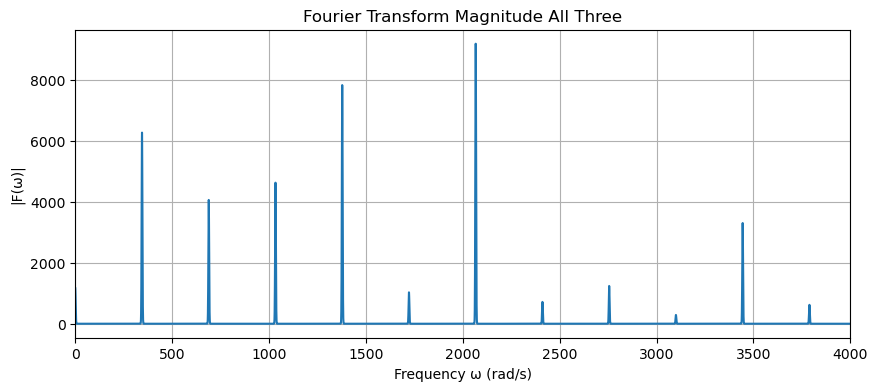

In [42]:
data = pd.read_csv("./plot_data/All Three.csv", header=None)
res = visualizeFourierTransform(data, "All Three", 1000)